# 0.0 IMPORTS

In [80]:
import pandas   as pd
import numpy    as np
import seaborn  as sns
import inflection
import warnings
import re
import umap.umap_ as umap
import matplotlib.cm as cm
import datetime

from matplotlib    import pyplot     as plt
from plotly        import express    as px
from scipy.cluster import hierarchy  as hc


from sklearn             import cluster       as c
from sklearn             import metrics       as mt
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn.manifold    import TSNE
from sklearn             import ensemble      as en
from sklearn.mixture     import GaussianMixture

warnings.filterwarnings('ignore')

## 0.2 Loading Data

In [2]:
path = 'C:/Users/edils/repos/customer_fidelity/data/'

In [3]:
df_raw = pd.read_csv(path + 'ecommerce.csv', encoding='windows-1252')

In [4]:
df_raw = df_raw.drop('Unnamed: 8', axis=1)

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

In [7]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename Columns

In [8]:
df1.columns = df1.columns.map(lambda x: inflection.underscore(x))

## 1.2 Data Dimensions

In [9]:
df1.shape

(541909, 8)

## 1.3 Data Types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [12]:
df_missing = df1.loc[pd.isnull(df1['customer_id']),:]

In [13]:
#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

#merge
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce - combina o que tem NaN em uma coluna com o que não tem em outra
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns
df1 = df1.drop(['customer_id_x','customer_id_y'], axis=1)

## 1.6 Change Types

In [14]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

## 1.7 Descriptive Statistics

In [15]:
numerical_attributes = df1.select_dtypes(include=['float64', 'int64', 'datetime64[ns]'])
categorical_atributtes = df1.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

## 1.7.1 Numerical Analysis

In [16]:
disp = numerical_attributes.agg(['mean','median','std','min','max',lambda x: max(x) - min(x), 'skew', 'kurtosis']).T.rename(columns={'<lambda>':'range'})

In [17]:
disp

,mean,median,std,min,max,range,skew,kurtosis
quantity,9.55225,3.0,218.081158,-80995.0,80995.0,161990.0,-0.264076,119769.160031
invoice_date,2017-07-02 00:00:13.073782016,2017-07-17 00:00:00,115 days 21:02:59.177457004,2016-11-29 00:00:00,2017-12-07 00:00:00,373 days 00:00:00,NaN,NaN
unit_price,4.611114,2.08,96.759853,-11062.06,38970.0,50032.06,186.506972,59005.719097
customer_id,16688.840453,16249.0,2911.411352,12346.0,22709.0,10363.0,0.487449,-0.804287


Podemos ver que existes dados grandes e negativos em 'quantity'e também produtos igual a 0.0 em unit_price

## 1.7.2 Categorical Atributtes

In [18]:
categorical_atributtes

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom
...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,France


In [19]:
#invoice_no
letter_lines = categorical_atributtes['invoice_no'].apply(lambda x: bool (re.search('[a-zA-Z]', x)))
letter_df = df1.loc[letter_lines,'quantity']
any(letter_df >0)

True

In [20]:
#stock_code
stock_letter = categorical_atributtes['stock_code'].apply(lambda x: bool (re.search('^[a-zA-Z]+$', x)))
stock_df = df1.loc[stock_letter,:]

In [21]:
stock_df['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [22]:
#country - European Community and Unspecified
df1['country'].unique()
df1.loc[:,['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 VARIABLE FILTERING

In [23]:
df2 = df1.copy()

## 2.1 Numerical Attributes

In [24]:
#unit_price
df2 = df2.loc[df2['unit_price'] >= 0.040,:]

#stock code
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']),:]

#description
df2 = df2.drop('description', axis=1)

#country
df2 = df2.loc[~df2['country'].isin(['Unspecified','European Community']),:]

#bad users

df2 = df2.loc[~df2['customer_id'].isin([16446]),:]


Deixei apenas preços acima de 0. Letras do Stock code que poluem os dados. Description não ajuda na clusterização e Países da União europeia já são repetidos e Países Não especificados poluem os dados

In [25]:
#divide df in purchases and returns
df_purchase = df2.loc[df2['quantity'] >=0, :]
df_returns = df2.loc[df2['quantity'] < 0,:]

# 3.0 FEATURE ENGINEERING

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850.0


## 3.1 Monetary 

In [28]:
#Monetary - O quanto cada cliente gera de $
aux_monetary = pd.DataFrame()
aux_monetary['valor_bruto'] = df_purchase['quantity'] * df_purchase['unit_price']
aux_monetary['customer_id'] = df_purchase['customer_id']
df_ref = aux_monetary.loc[:,['valor_bruto', 'customer_id']].groupby('customer_id').sum().reset_index().rename(columns={'valor_bruto':'monetary'})
df_ref.isna().sum()

customer_id    0
monetary       0
dtype: int64

## 3.2 Qtd de Compras

In [29]:
#Quantos produtos cada cliente comprou
aux_invoice = df_purchase.loc[:,['invoice_no','customer_id']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qtd_compras'})
df_ref = pd.merge(df_ref, aux_invoice, on='customer_id', how='left')
df_ref.isna().sum()

customer_id    0
monetary       0
qtd_compras    0
dtype: int64

## 3.4 Qtd produtos comprados

In [30]:
#Quantos produtos cada cliente comprou
aux_qtd = df_purchase.loc[:,['quantity','customer_id']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtd_items'})
df_ref = pd.merge(df_ref, aux_qtd, on='customer_id', how='left')
df_ref.isna().sum()

customer_id    0
monetary       0
qtd_compras    0
qtd_items      0
dtype: int64

## 3.5 Qtd produtos únicos dentro da compra (stock_code)

In [31]:
#Quantos produtos cada cliente comprou
aux_qtd_stock = df_purchase.loc[:,['stock_code','customer_id']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qtd_prods'})
df_ref = pd.merge(df_ref, aux_qtd_stock, on='customer_id', how='left')
df_ref.isna().sum()

customer_id    0
monetary       0
qtd_compras    0
qtd_items      0
qtd_prods      0
dtype: int64

## 3.6 Recency

In [32]:
#Recency
aux_recency = df_purchase.loc[:,['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
date_max = df_purchase['invoice_date'].max()
aux_recency['recency'] = (date_max - aux_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, aux_recency, on='customer_id', how='left')
df_ref = df_ref.drop(['invoice_date'],axis=1)
df_ref.isna().sum()

customer_id    0
monetary       0
qtd_compras    0
qtd_items      0
qtd_prods      0
recency        0
dtype: int64

## 3.7 Average Ticket

In [33]:
#Ticket Médio
aux_ticket = aux_monetary.loc[:,['valor_bruto', 'customer_id']].groupby('customer_id').mean().reset_index().rename(columns={'valor_bruto':'avg_ticket'})
df_ref = pd.merge(df_ref, aux_ticket, on='customer_id', how='left') 
df_ref.isna().sum()

customer_id    0
monetary       0
qtd_compras    0
qtd_items      0
qtd_prods      0
recency        0
avg_ticket     0
dtype: int64

## 3.8 Average Recency Days

In [34]:
aux_rd = df3.loc[:,['invoice_date','customer_id']].drop_duplicates().sort_values(by=['customer_id','invoice_date'])
aux_rd['previous_customer'] = aux_rd['customer_id'].shift() #next customer
aux_rd['previous_invoice'] = aux_rd['invoice_date'].shift() #next date
aux_rd['avg_recency_days'] = aux_rd.apply(lambda x: (x['invoice_date'] - x['previous_invoice']).days if x['previous_customer'] == x['customer_id'] else np.nan, axis=1)
aux_rd = aux_rd.dropna()

#drop support columns
aux_rd = aux_rd.drop(['invoice_date','previous_customer','previous_invoice'], axis=1)

#calculate avg recency
aux_rd_avg = aux_rd.groupby('customer_id').mean().reset_index()

#merge
df_ref = pd.merge(df_ref, aux_rd_avg, on='customer_id', how='left')


In [35]:
df_ref.isna().sum()

customer_id            0
monetary               0
qtd_compras            0
qtd_items              0
qtd_prods              0
recency                0
avg_ticket             0
avg_recency_days    2727
dtype: int64

## 3.9 Frenquency Purchase

In [36]:
df_freq = (df_purchase[['customer_id','invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                           .agg(days = ('invoice_date', lambda x: (max(x) - min(x)).days + 1),
                                                                buy_ = ('invoice_no', 'count'))).reset_index()

#Frequency
df_freq['frequency'] = df_freq.apply(lambda x: x['buy_'] / x['days'] if x['days'] != 0 else 0, axis=1) 

#merge
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref = df_ref.drop(['days','buy_'],axis=1)

In [37]:
df_ref.isna().sum()

customer_id            0
monetary               0
qtd_compras            0
qtd_items              0
qtd_prods              0
recency                0
avg_ticket             0
avg_recency_days    2727
frequency              0
dtype: int64

## 3.10 Devoluções

In [38]:
qtd_returns = df_returns.loc[:,['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtd_returns'})
qtd_returns['qtd_returns'] = qtd_returns['qtd_returns']*-1

#merge
df_ref = pd.merge(df_ref, qtd_returns, on='customer_id', how='left')

#Os NaNs gerados são pessoas que não devolveram
df_ref.loc[df_ref['qtd_returns'].isna(),'qtd_returns'] = 0

In [39]:
df_ref.isna().sum()

customer_id            0
monetary               0
qtd_compras            0
qtd_items              0
qtd_prods              0
recency                0
avg_ticket             0
avg_recency_days    2727
frequency              0
qtd_returns            0
dtype: int64

## 3.11 Unique Basket Size

In [40]:
#qtd de produtos diferentes dentro de uma compora
basket_size = df_purchase.loc[:,['customer_id','stock_code','invoice_no']].groupby(['customer_id']).nunique().reset_index()

#media itens por compra
basket_size['unique_avg_basket'] = basket_size['stock_code'] / basket_size['invoice_no']

#merge
df_ref = pd.merge(df_ref, basket_size[['customer_id','unique_avg_basket']], on='customer_id', how='left')

In [41]:
df_ref.isna().sum()

customer_id             0
monetary                0
qtd_compras             0
qtd_items               0
qtd_prods               0
recency                 0
avg_ticket              0
avg_recency_days     2727
frequency               0
qtd_returns             0
unique_avg_basket       0
dtype: int64

## 3.12 Quantity Basket Size - Quantidade de produtos por basket

In [42]:
#qtd de produtos medios por compra
qtd_basket_size = (df_purchase.loc[:,['customer_id','quantity','invoice_no']].groupby(['customer_id'])
                                                                            .agg(uniq_prod = ('invoice_no', 'nunique'),
                                                                                 quantity_sum = ('quantity', 'sum'))).reset_index()    

#media de quantidade de itens por basket
qtd_basket_size['avg_basket'] = qtd_basket_size['quantity_sum'] / qtd_basket_size['uniq_prod']

#merge
df_ref = pd.merge(df_ref, qtd_basket_size[['customer_id','avg_basket']], on='customer_id',how='left')

In [43]:
df_ref.isna().sum()

customer_id             0
monetary                0
qtd_compras             0
qtd_items               0
qtd_prods               0
recency                 0
avg_ticket              0
avg_recency_days     2727
frequency               0
qtd_returns             0
unique_avg_basket       0
avg_basket              0
dtype: int64

## 3.13 Check Final Result

In [44]:
df_ref.head()

,customer_id,monetary,qtd_compras,qtd_items,qtd_prods,recency,avg_ticket,avg_recency_days,frequency,qtd_returns,unique_avg_basket,avg_basket
0,12346.0,77183.60,1,74215,1,325,77183.600000,NaN,1.000000,74215.0,1.000000,74215.000000
1,12347.0,4310.00,7,2458,182,2,23.681319,60.833333,0.019126,0.0,14.714286,351.142857
2,12348.0,1437.24,4,2332,27,75,53.231111,94.333333,0.014085,0.0,5.250000,583.000000
3,12349.0,1457.55,1,630,72,18,20.243750,NaN,1.000000,0.0,72.000000,630.000000
4,12350.0,294.40,1,196,16,310,18.400000,NaN,1.000000,0.0,16.000000,196.000000


# 4.0 EDA (EXPLORATORY DATA ANALYSIS

In [45]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id          0
monetary             0
qtd_compras          0
qtd_items            0
qtd_prods            0
recency              0
avg_ticket           0
avg_recency_days     0
frequency            0
qtd_returns          0
unique_avg_basket    0
avg_basket           0
dtype: int64

## 4.3 Embedding

In [46]:
#selected dataset
cols_selected = ['customer_id', 'monetary', 'recency', 'qtd_prods', 'frequency', 'qtd_returns']
df43 = df4[cols_selected].copy()

In [47]:
df43.shape

(2968, 6)

In [48]:
#Transform
mms = pp.MinMaxScaler()
transf_list = df43.columns.drop('customer_id')

for i in transf_list:
    df43[i] = mms.fit_transform(df43[i].values.reshape(-1,1))  

## 4.3.4 Tree-Based Embedding

In [49]:
X = df43.drop(['customer_id','monetary'], axis=1).copy()
y = df43['monetary'].copy()

In [50]:
#model definition
rf = en.RandomForestRegressor(random_state=0)

rf.fit(X, y)

#create leafs
df_leafs = pd.DataFrame(rf.apply(X))

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

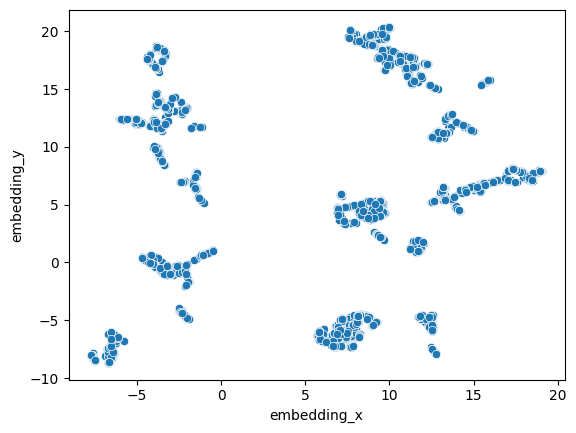

In [51]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leafs)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_tree)

# 7.0 HYPERPARAMETER FINE TUNNING(Find Clusters)

In [52]:
X = df_tree.copy()

In [53]:
X.head()

,embedding_x,embedding_y
0,12.615181,11.044086
1,-6.499238,-8.245778
2,9.478956,5.369207
3,7.712303,-7.336355
4,-3.489240,18.404636


# 8.0 MODEL TRAINING

## 8.3 HCluster - FAVORITO

In [54]:
k=7
#model definition & training
hc_model = hc.linkage(X, 'ward')

#model predict
labels_hc = hc.fcluster(hc_model, k, criterion='maxclust')

In [55]:
print(f'SS Score: {mt.silhouette_score(X, labels_hc):.3f}')

SS Score: 0.621


# 9.0 CLUSTER ANALYSIS

## 9.5 Cluster Profile

In [92]:
df_deploy = df4[cols_selected].copy()
df_deploy['clusters'] = labels_hc  

#change types
df_deploy['customer_id'] = df_deploy['customer_id'].astype(int)
df_deploy['qtd_returns'] = df_deploy['qtd_returns'].astype(int)
df_deploy['clusters'] = df_deploy['clusters'].astype(int)

#save last training
df_deploy['last_training'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [83]:
#Per Monetary
df_monetary = df_deploy.loc[:,['clusters','monetary']].groupby('clusters').mean().reset_index()

#Per Frequency
df_frequency = df_deploy.loc[:,['clusters','frequency']].groupby('clusters').mean().reset_index()

#Per Recency
df_recency = df_deploy.loc[:,['clusters','recency']].groupby('clusters').mean().reset_index()

#Per Pencentual
df_client_perc = df_deploy.loc[:,['customer_id','clusters']].groupby('clusters').count().reset_index()
df_client_perc['customer_id'] = df_client_perc['customer_id'].apply(lambda x: 100*(x)/(df_client_perc['customer_id'].sum()))
df_client_perc = df_client_perc.rename(columns={'customer_id':'percent'})

#Per qtd_products
df_prods = df_deploy.loc[:,['clusters','qtd_prods']].groupby('clusters').mean().reset_index()

#Per Returns
df_returns = df_deploy.loc[:,['clusters','qtd_returns']].groupby('clusters').mean().reset_index()

#Per Customer
df_customer = df_deploy.loc[:,['clusters','customer_id']].groupby('clusters').count().reset_index()

df_resume = (pd.merge(df_monetary, df_frequency, on='clusters', how='left')
             .merge(df_recency, on='clusters', how='left')
             .merge(df_client_perc, on='clusters', how='left')
             .merge(df_prods, on='clusters', how='left')
             .merge(df_returns, on='clusters', how='left')
             .merge(df_customer, on='clusters', how='left'))


In [84]:
df_resume

,clusters,monetary,frequency,recency,percent,qtd_prods,qtd_returns,customer_id
0,1,2121.153140,0.047337,57.132000,16.846361,67.232000,10.740000,500
1,2,819.306358,0.124034,85.728395,5.458221,27.944444,4.000000,162
2,3,971.025435,0.074586,75.329193,10.849057,37.462733,6.571429,322
3,4,568.228161,0.298414,116.712644,20.518868,14.123153,16.110016,609
4,5,9618.034548,0.103263,20.707143,14.150943,447.840476,166.235714,420
5,6,1685.240506,0.050577,55.002532,13.308625,88.929114,10.313924,395
6,7,2566.060375,0.044631,40.462500,18.867925,147.032143,20.912500,560


### Cluster 05 (Insiders)


- Número de customers = 420
- Recência Média = 20.70 dias
- Faturamento Médio = R$9618.03
- Média de Produtos Comprados = 447 produtos
- Frequência de Produtos Comprados = 0.1032 produtos comprados/dia

Cluster 0 - Clientes Esporádicos
    - Clientes que comprar pouco, valor baixo, e com uma média de 3 meses. Porém engloba 99% dos clientes
    
Cluster 1 - Clientes Medianos
    - Clientes que compram em média uma vez por mês mas uma quantia maior e um valor maior que os Esporádicos
    
Cluster 2 - Clientes elegíveis a Insiders
    - Gastam muito, toda semana e compram bastante produtos

# 11.0 DEPLOY TO PRODUCTION

In [85]:
df_deploy.head()

,customer_id,monetary,recency,qtd_prods,frequency,qtd_returns,clusters,last_training
1,12347,4310.00,2,182,0.019126,0,7,2023-06-22 14:35:09
2,12348,1437.24,75,27,0.014085,0,2,2023-06-22 14:35:09
5,12352,1385.74,36,77,0.026820,63,6,2023-06-22 14:35:09
9,12356,2487.43,22,58,0.009868,0,1,2023-06-22 14:35:09
11,12358,928.06,1,17,0.013333,0,4,2023-06-22 14:35:09


In [86]:
df_deploy.dtypes

customer_id        int64
monetary         float64
recency            int64
qtd_prods          int64
frequency        float64
qtd_returns        int64
clusters           int64
last_training     object
dtype: object

## 11.1 Insert into SQLITE

In [87]:
import sqlite3
from sqlalchemy import create_engine, text

In [88]:
# #create table
# query_create_table_insiders = """
#     CREATE TABLE insiders (
#         customer_id INTEGER,
#         monetary    REAL,
#         recency     INTEGER,
#         qtd_prods   INTEGER,
#         frequency   REAL,
#         qtd_returns INTEGER,
#         clusters    INTEGER   
#     )
#     """  
 
# conn = sqlite3.connect('insiders_db.sqlite') 
# conn.execute(query_create_table_insiders)
# conn.commit()
# conn.close()

# #insert data - append
# conn = create_engine('sqlite:///insiders_db.sqlite')
# df_deploy.to_sql('insiders', con=conn, if_exists='append', index=False)
# conn.close()

# #insert data - replace
# conn = create_engine('sqlite:///insiders_db.sqlite')
# df_deploy.to_sql('insiders', con=conn, if_exists='replace', index=False)
# conn.close()

# #select data

2968

In [89]:
#consulting database
engine = create_engine('sqlite:///insiders_db.sqlite')
query = """
    SELECT * FROM insiders
"""

df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [91]:
df

,customer_id,monetary,recency,qtd_prods,frequency,qtd_returns,clusters,last_training
0,12347,4310.00,2,182,0.019126,0,7,2023-06-22 14:35:09
1,12348,1437.24,75,27,0.014085,0,2,2023-06-22 14:35:09
2,12352,1385.74,36,77,0.026820,63,6,2023-06-22 14:35:09
3,12356,2487.43,22,58,0.009868,0,1,2023-06-22 14:35:09
4,12358,928.06,1,17,0.013333,0,4,2023-06-22 14:35:09
...,...,...,...,...,...,...,...,...
2963,18276,335.86,43,14,1.000000,2,4,2023-06-22 14:35:09
2964,18277,110.38,58,8,1.000000,1,4,2023-06-22 14:35:09
2965,18282,178.05,7,12,0.016667,5,4,2023-06-22 14:35:09
2966,18283,2088.93,3,754,0.047761,0,5,2023-06-22 14:35:09
